In [28]:
%load_ext autoreload
%autoreload 2
import os
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torch.nn.functional as F 
from torch import autograd
from torch import optim
from torch.autograd import Variable
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torchvision
from torchvision.utils import save_image
import torch.backends.cudnn as cudnn
import torch.nn as nn
import json
import util
from tqdm import tqdm_notebook
from models import *

cudnn.benchmark = True
from advertorch.attacks import LinfPGDAttack, L2PGDAttack
from advertorch.utils import NormalizeByChannelMeanStd
import random
import kornia

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
MEAN = torch.Tensor([0.4914, 0.4822, 0.4465])
STD = torch.Tensor([0.2023, 0.1994, 0.2010])


def unnormalize(im):
    mean = MEAN.cuda() if im.is_cuda else MEAN
    std = STD.cuda() if im.is_cuda else STD

    if im.dim() == 4:
        im = im.transpose(1, 3)
        im = im * std + mean
        im = im.transpose(1, 3)
    else:
        im = im.transpose(0, 2)
        im = im * std + mean
        im = im.transpose(0, 2)

    return im


def normalize(im):
    mean = MEAN.cuda() if im.is_cuda else MEAN
    std = STD.cuda() if im.is_cuda else STD

    if im.dim() == 4:
        im = im.transpose(1, 3)
        im = (im - mean) / std
        im = im.transpose(1, 3)
    else:
        im = im.transpose(0, 2)
        im = (im - mean) / std
        im = im.transpose(0, 2)

    return im

def BIM(image, classifier, target, max_eps, itr_eps=1 / 255, itr=20):
    eps = torch.zeros_like(image).cuda()
    for _ in range(itr):
        eps.requires_grad = True
        with torch.enable_grad():
            output = classifier(normalize((image+eps).clamp(0,1)))
            loss = F.cross_entropy(
                output, target, size_average=False
            )
        grad = torch.autograd.grad(loss, [eps])[0]
        eps = eps + itr_eps * torch.sign(grad.detach())
        eps = eps.clamp(-max_eps, max_eps).detach()
    return eps

transform = transforms.Compose([
    transforms.ToTensor(),
])


criterion = nn.CrossEntropyLoss()
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# criterion = nn.MSELoss()

norm = NormalizeByChannelMeanStd(
    mean=MEAN, std=STD)

classifier = torch.nn.DataParallel(ResNet18()).cuda().eval()
classifier_feat = torch.nn.DataParallel(ResNet18_feat()).cuda().eval()

checkpoint = torch.load('./checkpoint/ckpt.t7')
# checkpoint = torch.load('./checkpoint/ckpt_ccumulate_10_scale1_warm1.t7')
classifier.load_state_dict(checkpoint['net'])
classifier_feat.load_state_dict(checkpoint['net'])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# trainset = torchvision.datasets.ImageFolder(root='./robust_data', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

out_dir = './robust_data_multiadv'
util.create_dirs(out_dir)
for i in range(10):
    util.create_dirs(os.path.join(out_dir, str(i)))

max_eps = 8/255


classifier = nn.Sequential(norm, classifier).cuda()

adversary = LinfPGDAttack(
    classifier, eps=8. / 255, eps_iter=2 / 255, nb_iter=10,
    rand_init=True, targeted=False)

strong_adversary = LinfPGDAttack(
    classifier, eps=8. / 255, eps_iter=1 / 255, nb_iter=50,
    rand_init=True, targeted=False)

# eps = 1.
# adversary = L2PGDAttack(
#     classifier, eps=eps, eps_iter=eps/5, nb_iter=10,
#     rand_init=True, targeted=False)

# adversary = L2PGDAttack(
#     adv_model, eps=eps, eps_iter=eps/10, nb_iter=30,
#     rand_init=True, targeted=False)

Files already downloaded and verified


In [37]:
def new_robustify(im, target, iterations, classifier):
    with torch.no_grad():
        target_feat, _ = classifier_feat(normalize(im))
        
    index = torch.randperm(im.size(0)).cuda()
    im = im[index] 

    for j in tqdm_notebook(range(iterations)):
        im.requires_grad_()
        total_loss = 0

        eps = (adversary.perturb(im, target) - im).detach()
        output = classifier(normalize((im + eps).clamp(0, 1)))
        xe_loss =criterion(output, target) 
        
        output_feat, _ = classifier_feat(normalize((im).clamp(0, 1)))
        feat_loss = 1e-1 * F.mse_loss(output_feat[-1], target_feat[-1])
        
        print(j, xe_loss.item(), feat_loss.item())
        total_loss = total_loss + xe_loss + feat_loss
        if xe_loss < 1e-4:
            return im.clamp(0,1)
        
        total_loss.backward()
        im = (im - 0.5/255*im.grad.data.sign()).clamp(0,1).detach()
#         im = (im - 0.1*im.grad.data/im.grad.data.norm(2, dim=(1,2,3))[:,None,None,None]).clamp(0,1).detach()

    out = (im).clamp(0, 1)
    return out

def madry_robustify(im, iterations=1000):
    index = torch.randperm(im.size(0)).cuda()
    shuffled_im = im[index] 
    with torch.no_grad():
        target_feat, _ = classifier_feat(normalize(im))
    
    for i in range(iterations):
        shuffled_im.requires_grad_()
        output_feat, _ = classifier_feat(normalize(shuffled_im))
        loss = F.mse_loss(output_feat[-1], target_feat[-1])
        loss.backward()
        shuffled_im = (shuffled_im - 0.1*shuffled_im.grad.data/shuffled_im.grad.data.norm(2, dim=(1,2,3))[:,None,None,None]).clamp(0,1).detach()
        
    return shuffled_im

def jitter(X, max_jitter=16):
    """
    Helper function to randomly jitter an image.
    
    Inputs
    - X: PyTorch Tensor of shape (N, C, H, W)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes
    
    Returns: A new PyTorch Tensor of shape (N, C, H, W)
    """
    ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X

def transformation(x):
#     x = F.pad(x, (4,4,4,4), 'constant', 0.5)
    x = jitter(x, 4)
#     x = F.interpolate(x, scale_factor=np.random.uniform(0.9, 1.1), mode="bilinear")
    rotations = list(range(-10, 11)) + 5 * [0]
    angle = torch.ones(1) * random.choice(rotations)
    center = torch.ones(1, 2)
    center[..., 0] = x.shape[3] / 2  # x
    center[..., 1] = x.shape[2] / 2  # y
    M = kornia.get_rotation_matrix2d(center, angle, scale=torch.FloatTensor([np.random.uniform(0.8, 1.2)])).cuda()
    M = M.expand(x.size(0), -1, -1)
    _, _, h, w = x.shape
    x = kornia.warp_affine(x, M, dsize=(h, w))    
    x = jitter(x, 2)
    return x

def test_robustify(im, target, iterations, count,  classifier):
    with tqdm_notebook(total=iterations, leave=False) as t:
        for j in range(iterations):
            im.requires_grad_()
            total_loss = 0
            

#             eps = (adversary.perturb(im, target) - im).detach()
#             output = classifier((im + eps).clamp(0, 1))
#             loss = F.cross_entropy(output, target, reduction='none')
#             total_loss += loss.mean()
            
            t_im = transformation(im)
            eps = (adversary.perturb(t_im, target) - t_im).detach()
            t_output = classifier(t_im+eps)
            t_loss = criterion(t_output, target)
            total_loss += t_loss
            
            equal_idx = ((t_output.argmax(1) == target) * (t_loss < 1e-5))

            total_loss.backward()
            im = (im - 0.2*im.grad.data/im.grad.data.norm(2, dim=(1,2,3))[:,None,None,None]).clamp(0,1).detach()
    
            for idx in equal_idx.nonzero():
                save_image(im[idx].clamp(0,1), os.path.join(out_dir, str(target[idx].item()), '%d.png'%(count[int(target[idx])])))
                count[int(target[idx])] += 1
            im = im[1-equal_idx]
            target = target[1-equal_idx]
            if im.size(0) == 0:
                return count

    
            t.set_postfix(l1='{:03.7f}'.format(t_loss.item()))
            t.update()
            
        for idx in range(im.size(0)):
            save_image(im[idx].clamp(0,1), os.path.join(out_dir, str(target[idx].item()), '%d.png'%(count[int(target[idx])])))
            count[int(target[idx])] += 1
    return count

In [4]:
z = torch.tensor([1,2,3,4])
y = torch.tensor([1,2,5,4])
x = torch.tensor([.1,.2,.1,.1])

eq = ((z==y) * (x < .15))
print(eq.nonzero())
for i in eq.nonzero():
    print(i, i.shape)
z[1-eq]

tensor([[0],
        [3]])
tensor([0]) torch.Size([1])
tensor([3]) torch.Size([1])


tensor([2, 3])

In [ ]:
iterations = 500
count = [0] * 10
for batch_idx, (inputs, targets) in enumerate(tqdm_notebook(trainloader)):
    inputs = inputs.cuda()
    targets = targets.cuda()

    out = inputs
    count = test_robustify(inputs, targets, iterations, count, classifier)

#     for i in range(inputs.size(0)):
#         save_image(out[i], os.path.join(out_dir, str(targets[i].item()), '%d.png'%(count[int(targets[i])])))
#         count[int(targets[i])] += 1

In [24]:
for batch_idx, (inputs, targets) in enumerate(tqdm_notebook(trainloader)):
    break

inputs = inputs.cuda()
targets = targets.cuda()
out = inputs.clone()
# out_madry = inputs.clone()
out = test_robustify(out, targets, 500, classifier)
# out_madry = madry_robustify(out)

In [25]:
adv_out = strong_adversary.perturb(out, targets)

plane
plane
plane


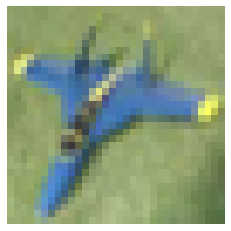

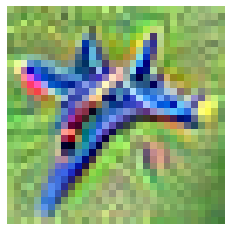

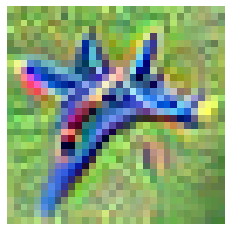

In [27]:
idx = 0
util.display_image(inputs[idx])
print(classes[classifier(inputs).argmax(1)[idx]])
util.display_image(out[idx])
print(classes[classifier(out).argmax(1)[idx]])
util.display_image(adv_out[idx])
print(classes[classifier(adv_out).argmax(1)[idx]])

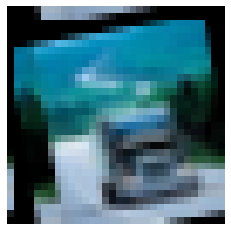

In [8]:
util.display_image(transformation(inputs[idx, None]))


In [ ]:
# save_image(out, 'robust.png')
# adv = util.BIM(out.detach(), classifier, targets, 8/255, itr_eps=1 / 255, itr=20)
strong_adversary = L2PGDAttack(
    adv_model, eps=0.5, eps_iter=0.25/5, nb_iter=100,
    rand_init=True, targeted=False)

adv = strong_adversary.perturb(out_madry.detach(), targets)
robust_label = classifier(out).argmax(1)
adv_label = classifier(adv).argmax(1)

print((targets==robust_label).sum().float()/ inputs.size(0))
print((targets==adv_label).sum().float()/inputs.size(0))

classifier_dense = torch.nn.DataParallel(DenseNet121()).cuda().eval()
checkpoint = torch.load('./checkpoint/ckpt_dense.t7')
classifier_dense.load_state_dict(checkpoint['net'])

dense_label = classifier_dense(normalize(out)).argmax(1)

print((targets==dense_label).sum().float()/ inputs.size(0))

In [ ]:
idx = 19
util.display_image(inputs[idx])
util.display_image(out[idx])
util.display_image(out_madry[idx])

In [ ]:
def mixup_data(x, y, alpha=0.5):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    
    y_onehot = torch.FloatTensor(x.size(0), 10).cuda()
    y_onehot.zero_()
    y_onehot.scatter_(1, y.unsqueeze(1), 1)

    mixed_x = (1-alpha) * x + (alpha) * x[index, :]
    mixed_y = (1-alpha) * y_onehot + alpha * y_onehot[index]
    return mixed_x, mixed_y

mix, mix_y = mixup_data(inputs, targets)
idx = 4
util.display_image(mix[idx])
util.display_image(inputs[idx])
print(classes[targets[idx]])

In [ ]:
MEAN = torch.Tensor([0.4914, 0.4822, 0.4465])
STD = torch.Tensor([0.2023, 0.1994, 0.2010])
norm = NormalizeByChannelMeanStd(mean=MEAN, std=STD)

net = nn.Sequential(norm, ResNet18()).cuda()
net = torch.nn.DataParallel(net)
print(len(net.state_dict().items()), [k for k,v in net.state_dict().items()], '\n')

checkpoint = torch.load('./checkpoint/ckpt_madry+grad.t7')
print(len(checkpoint['net'].items()), [k for k,v in checkpoint['net'].items()])

# a = list(net.state_dict())
# sorted(a)
# b= list(checkpoint['net'])
# sorted(b)
# for i, key in enumerate(a):
#     key2 = b[i]
#     print(i, key, key2)
#     checkpoint['net'][key] = checkpoint['net'].pop(key2)

print([k for k,v in checkpoint['net'].items()])
torch.save(checkpoint, './checkpoint/ckpt_madry+grad.t7')

In [ ]:
c = 9
x = Image.open('./dataset_folder/robust_data/%d/10.png'%c)
x = transform(x).unsqueeze(0)
util.display_image(x)
print(classes[classifier(x).argmax(1)[0]])
adv = adversary.perturb(x.cuda(), torch.LongTensor([c]).cuda())
print(classes[classifier(adv).argmax(1)[0]])
